<a href="https://colab.research.google.com/github/hassaan145/Built-in-Functions/blob/master/Improvement_2(Demo2).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

HYBRID CNN-LSTM WITH DYNAMIC PSO FOR IoT INTRUSION DETECTION
Generating synthetic IoT network traffic data...
Dataset shape: (10000, 21)
Class distribution:
label
0.0    7000
1.0    3000
Name: count, dtype: int64

Data split:
Training set: (5600, 20)
Validation set: (1400, 20)
Test set: (3000, 20)

FEATURE SELECTION COMPARISON

Running Static PSO...
Iteration 10/30, Best Fitness: 0.9604
Iteration 20/30, Best Fitness: 0.9626
Iteration 30/30, Best Fitness: 0.9634

Static PSO Results:
Selected features: 9/20
Best fitness: 0.9634

Running Dynamic PSO with Real-time Adaptation...
Iteration 10/30, Best Fitness: 0.9629, Inertia: 0.750, Features: 10
Iteration 20/30, Best Fitness: 0.9629, Inertia: 0.583, Features: 7
Iteration 30/30, Best Fitness: 0.9629, Inertia: 0.417, Features: 7

Dynamic PSO Results:
Selected features: 7/20
Best fitness: 0.9629

Improvement: -0.04%


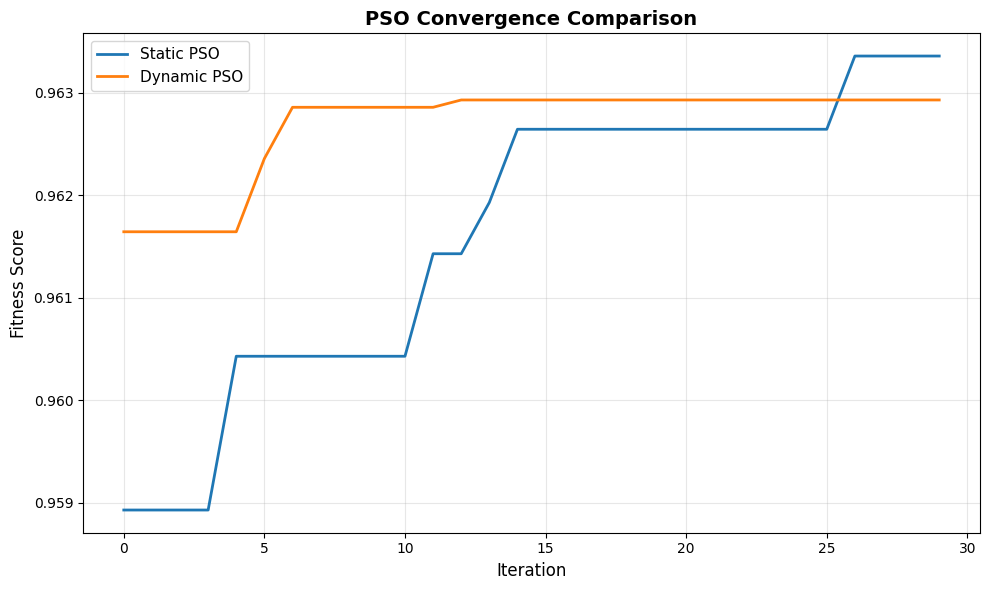


MODEL TRAINING AND EVALUATION

[1/4] Training CNN Model...
CNN Accuracy: 96.17%

[2/4] Training LSTM Model...
LSTM Accuracy: 95.77%

[3/4] Training CNN-LSTM Model...
CNN-LSTM Accuracy: 96.47%

[4/4] Training CNN-LSTM with Attention Model...
CNN-LSTM-Attention Accuracy: 96.47%

COMPREHENSIVE RESULTS COMPARISON

Model                     Accuracy     Precision    Recall       F1-Score    
--------------------------------------------------------------------------------
CNN                            96.17%       92.71%       94.67%       93.68%
LSTM                           95.77%       91.87%       94.22%       93.03%
CNN-LSTM                       96.47%       94.01%       94.22%       94.12%
CNN-LSTM-Attention             96.47%       94.01%       94.22%       94.12%

✓ Best performing model: CNN-LSTM with 96.47% accuracy

GENERATING VISUALIZATIONS


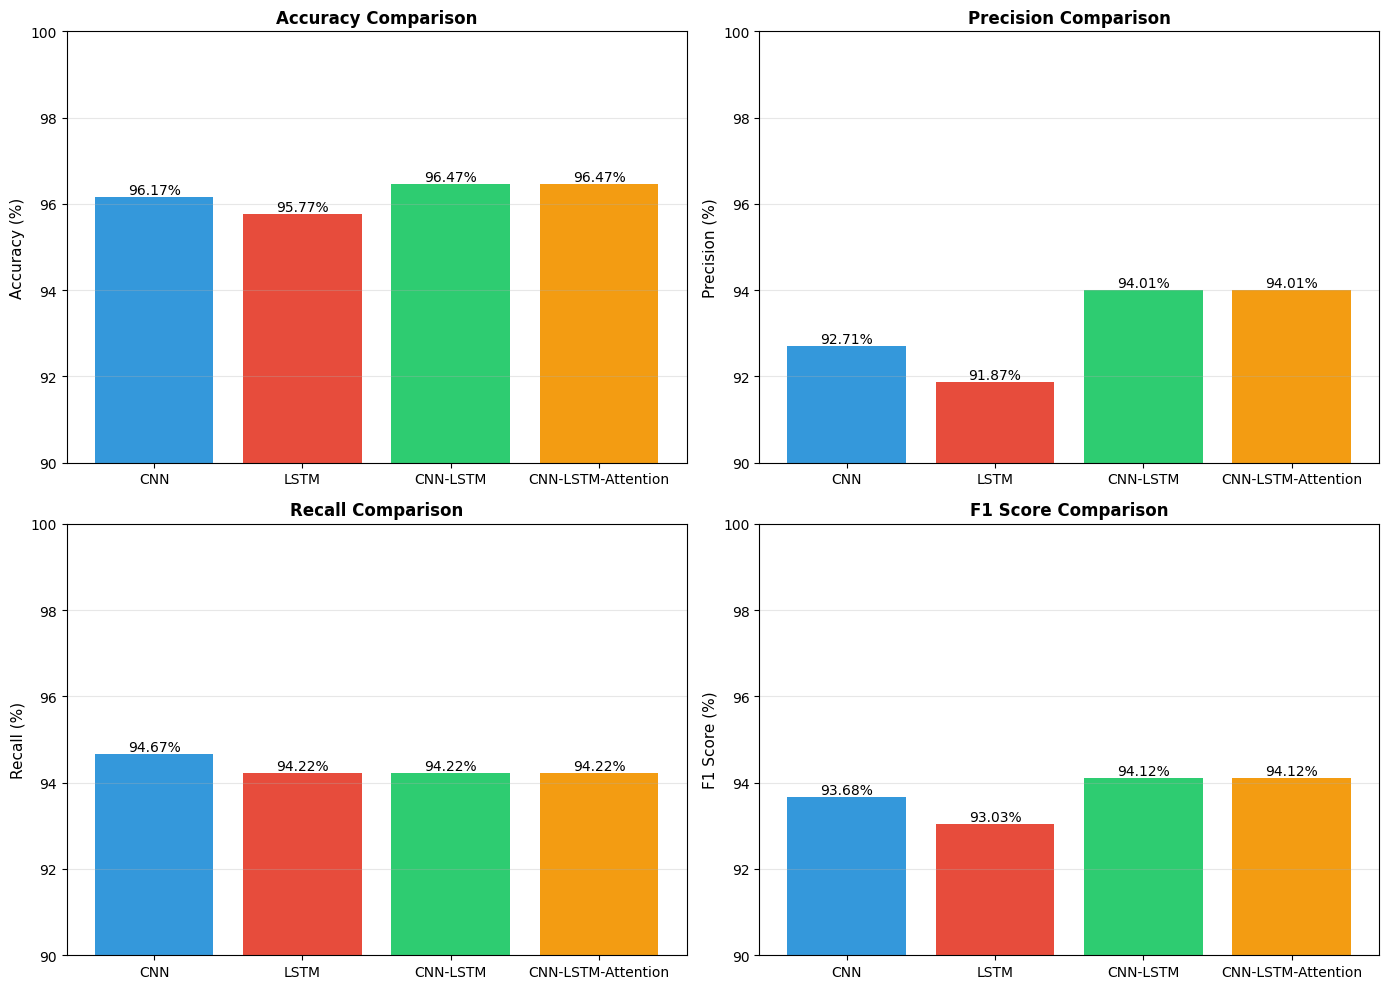

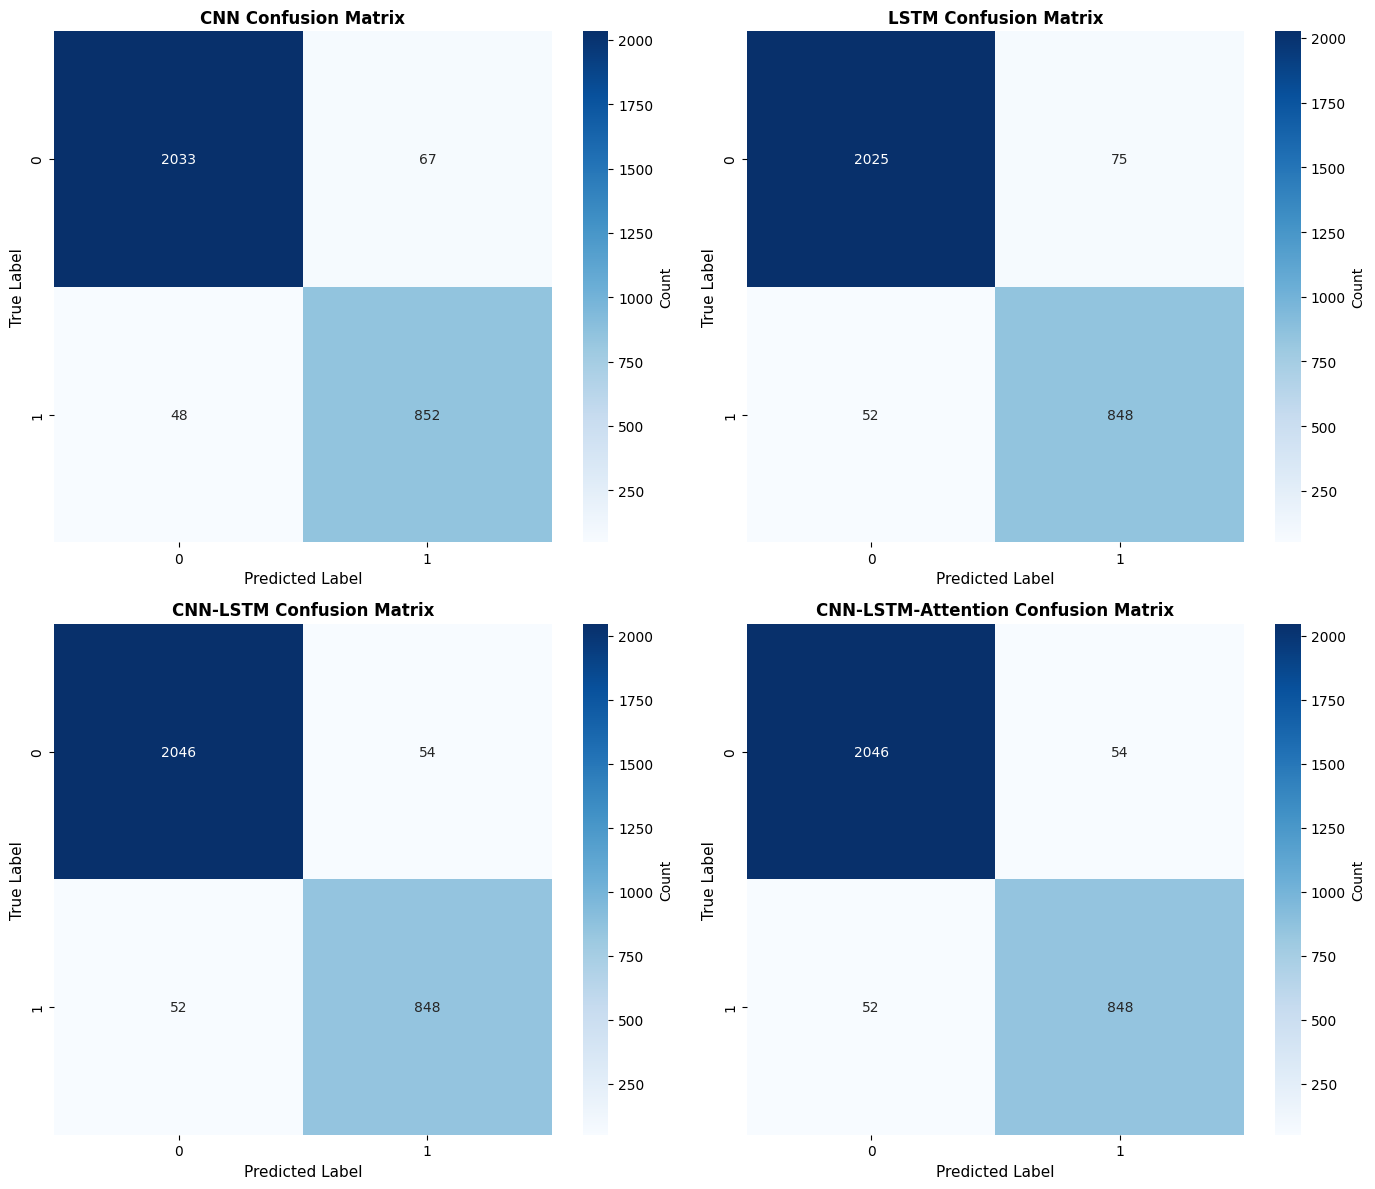


✓ Analysis complete! Visualizations saved as PNG files.


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                           f1_score, confusion_matrix, classification_report)
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Conv1D, LSTM, Dense, Dropout, MaxPooling1D,
                                    Bidirectional, Input, Multiply, Permute,
                                    RepeatVector, Flatten, Activation, Lambda)
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import backend as K
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# ==================== DATA LOADING AND PREPROCESSING ====================

def load_and_preprocess_data(file_path=None, use_synthetic=True):
    """
    Load IoT intrusion detection dataset
    If use_synthetic=True, generates synthetic data for demonstration
    """
    if use_synthetic or file_path is None:
        print("Generating synthetic IoT network traffic data...")
        n_samples = 10000
        n_features = 20

        # Generate synthetic features
        X = np.random.randn(n_samples, n_features)

        # Create patterns for normal vs attack traffic
        y = np.zeros(n_samples)

        # Attack patterns (30% of data)
        attack_indices = np.random.choice(n_samples, size=int(0.3*n_samples), replace=False)
        y[attack_indices] = 1

        # Make attacks have distinct patterns
        X[attack_indices, :5] *= 2.5  # Higher packet rates
        X[attack_indices, 5:10] += 1.5  # Different flag patterns

        feature_names = [f'feature_{i}' for i in range(n_features)]
        df = pd.DataFrame(X, columns=feature_names)
        df['label'] = y

    else:
        df = pd.read_csv(file_path)

    print(f"Dataset shape: {df.shape}")
    print(f"Class distribution:\n{df['label'].value_counts()}")

    return df

# ==================== PARTICLE SWARM OPTIMIZATION ====================

class StaticPSO:
    """Traditional Static PSO for Feature Selection"""

    def __init__(self, n_particles=30, n_iterations=50, w=0.7, c1=1.5, c2=1.5):
        self.n_particles = n_particles
        self.n_iterations = n_iterations
        self.w = w  # Inertia weight
        self.c1 = c1  # Cognitive parameter
        self.c2 = c2  # Social parameter

    def fitness_function(self, selected_features, X_train, X_val, y_train, y_val):
        """Evaluate fitness based on classification accuracy"""
        if selected_features.sum() == 0:
            return 0.0

        X_train_selected = X_train[:, selected_features.astype(bool)]
        X_val_selected = X_val[:, selected_features.astype(bool)]

        # Simple logistic regression for fitness evaluation
        from sklearn.linear_model import LogisticRegression
        clf = LogisticRegression(max_iter=100, random_state=42)
        clf.fit(X_train_selected, y_train)
        accuracy = clf.score(X_val_selected, y_val)

        # Penalize for too many features
        feature_penalty = 0.01 * selected_features.sum() / len(selected_features)

        return accuracy - feature_penalty

    def optimize(self, X_train, X_val, y_train, y_val):
        """Run static PSO optimization"""
        n_features = X_train.shape[1]

        # Initialize particles (positions and velocities)
        positions = np.random.rand(self.n_particles, n_features) > 0.5
        velocities = np.random.uniform(-1, 1, (self.n_particles, n_features))

        # Initialize personal best and global best
        p_best_positions = positions.copy()
        p_best_scores = np.array([self.fitness_function(pos, X_train, X_val, y_train, y_val)
                                  for pos in positions])

        g_best_idx = np.argmax(p_best_scores)
        g_best_position = p_best_positions[g_best_idx].copy()
        g_best_score = p_best_scores[g_best_idx]

        fitness_history = []

        print("\nRunning Static PSO...")
        for iteration in range(self.n_iterations):
            for i in range(self.n_particles):
                # Update velocity
                r1, r2 = np.random.rand(2)
                # Convert boolean arrays to integers for arithmetic operations
                cognitive = self.c1 * r1 * (p_best_positions[i].astype(int) - positions[i].astype(int))
                social = self.c2 * r2 * (g_best_position.astype(int) - positions[i].astype(int))
                velocities[i] = self.w * velocities[i] + cognitive + social

                # Update position (binary)
                sigmoid = 1 / (1 + np.exp(-velocities[i]))
                positions[i] = np.random.rand(n_features) < sigmoid

                # Ensure at least one feature is selected
                if positions[i].sum() == 0:
                    positions[i][np.random.randint(n_features)] = True

                # Evaluate fitness
                fitness = self.fitness_function(positions[i], X_train, X_val, y_train, y_val)

                # Update personal best
                if fitness > p_best_scores[i]:
                    p_best_scores[i] = fitness
                    p_best_positions[i] = positions[i].copy()

                    # Update global best
                    if fitness > g_best_score:
                        g_best_score = fitness
                        g_best_position = positions[i].copy()

            fitness_history.append(g_best_score)

            if (iteration + 1) % 10 == 0:
                print(f"Iteration {iteration+1}/{self.n_iterations}, Best Fitness: {g_best_score:.4f}")

        return g_best_position, g_best_score, fitness_history


class DynamicPSO:
    """Enhanced Dynamic PSO with Real-time Feature Adaptation"""

    def __init__(self, n_particles=30, n_iterations=50, w_max=0.9, w_min=0.4,
                 c1=1.5, c2=1.5, adaptation_rate=0.1):
        self.n_particles = n_particles
        self.n_iterations = n_iterations
        self.w_max = w_max  # Maximum inertia weight
        self.w_min = w_min  # Minimum inertia weight
        self.c1 = c1
        self.c2 = c2
        self.adaptation_rate = adaptation_rate  # Feature adaptation rate

    def fitness_function(self, selected_features, X_train, X_val, y_train, y_val):
        """Evaluate fitness with dynamic feature weighting"""
        if selected_features.sum() == 0:
            return 0.0

        X_train_selected = X_train[:, selected_features.astype(bool)]
        X_val_selected = X_val[:, selected_features.astype(bool)]

        from sklearn.linear_model import LogisticRegression
        clf = LogisticRegression(max_iter=100, random_state=42)
        clf.fit(X_train_selected, y_train)
        accuracy = clf.score(X_val_selected, y_val)

        # Dynamic penalty based on feature count
        feature_ratio = selected_features.sum() / len(selected_features)
        feature_penalty = 0.01 * feature_ratio

        return accuracy - feature_penalty

    def dynamic_feature_adjustment(self, position, feature_importance, iteration):
        """Dynamically adjust features based on importance scores"""
        n_features = len(position)

        # Calculate adaptation strength (decreases over iterations)
        adaptation_strength = self.adaptation_rate * (1 - iteration / self.n_iterations)

        # Probabilistically add/remove features based on importance
        for i in range(n_features):
            if np.random.rand() < adaptation_strength:
                if feature_importance[i] > 0.5 and not position[i]:
                    # Add important feature
                    position[i] = True
                elif feature_importance[i] < 0.3 and position[i]:
                    # Remove unimportant feature
                    position[i] = False

        # Ensure at least one feature is selected
        if position.sum() == 0:
            position[np.argmax(feature_importance)] = True

        return position

    def calculate_feature_importance(self, X_train, y_train, selected_features):
        """Calculate feature importance for dynamic adjustment"""
        if selected_features.sum() == 0:
            return np.ones(len(selected_features)) / len(selected_features)

        from sklearn.ensemble import RandomForestClassifier

        X_train_selected = X_train[:, selected_features.astype(bool)]
        clf = RandomForestClassifier(n_estimators=10, max_depth=5, random_state=42)
        clf.fit(X_train_selected, y_train)

        # Map importance back to all features
        importance = np.zeros(len(selected_features))
        importance[selected_features.astype(bool)] = clf.feature_importances_

        # Normalize
        if importance.sum() > 0:
            importance = importance / importance.sum()
        else:
            importance = np.ones(len(selected_features)) / len(selected_features)

        return importance

    def optimize(self, X_train, X_val, y_train, y_val):
        """Run dynamic PSO optimization with adaptive feature selection"""
        n_features = X_train.shape[1]

        # Initialize particles
        positions = np.random.rand(self.n_particles, n_features) > 0.5
        velocities = np.random.uniform(-1, 1, (self.n_particles, n_features))

        # Initialize personal best and global best
        p_best_positions = positions.copy()
        p_best_scores = np.array([self.fitness_function(pos, X_train, X_val, y_train, y_val)
                                  for pos in positions])

        g_best_idx = np.argmax(p_best_scores)
        g_best_position = p_best_positions[g_best_idx].copy()
        g_best_score = p_best_scores[g_best_idx]

        fitness_history = []
        feature_importance = np.ones(n_features) / n_features

        print("\nRunning Dynamic PSO with Real-time Adaptation...")
        for iteration in range(self.n_iterations):
            # Dynamic inertia weight (decreases linearly)
            w = self.w_max - (self.w_max - self.w_min) * iteration / self.n_iterations

            # Update feature importance periodically
            if iteration % 5 == 0:
                feature_importance = self.calculate_feature_importance(
                    X_train, y_train, g_best_position
                )

            for i in range(self.n_particles):
                # Update velocity with dynamic inertia
                r1, r2 = np.random.rand(2)
                # Convert boolean arrays to integers for arithmetic operations
                cognitive = self.c1 * r1 * (p_best_positions[i].astype(int) - positions[i].astype(int))
                social = self.c2 * r2 * (g_best_position.astype(int) - positions[i].astype(int))
                velocities[i] = w * velocities[i] + cognitive + social

                # Update position
                sigmoid = 1 / (1 + np.exp(-velocities[i]))
                positions[i] = np.random.rand(n_features) < sigmoid

                # Dynamic feature adjustment
                positions[i] = self.dynamic_feature_adjustment(
                    positions[i], feature_importance, iteration
                )

                # Evaluate fitness
                fitness = self.fitness_function(positions[i], X_train, X_val, y_train, y_val)

                # Update personal best
                if fitness > p_best_scores[i]:
                    p_best_scores[i] = fitness
                    p_best_positions[i] = positions[i].copy()

                    # Update global best
                    if fitness > g_best_score:
                        g_best_score = fitness
                        g_best_position = positions[i].copy()

            fitness_history.append(g_best_score)

            if (iteration + 1) % 10 == 0:
                print(f"Iteration {iteration+1}/{self.n_iterations}, "
                      f"Best Fitness: {g_best_score:.4f}, "
                      f"Inertia: {w:.3f}, "
                      f"Features: {g_best_position.sum()}")

        return g_best_position, g_best_score, fitness_history

# ==================== HYBRID CNN-LSTM WITH ATTENTION ====================

def attention_mechanism(inputs):
    """
    Attention mechanism for CNN-LSTM model
    Based on Bahdanau attention
    """
    # inputs shape: (batch_size, time_steps, features)
    attention_weights = Dense(1, activation='tanh')(inputs)
    attention_weights = Flatten()(attention_weights)
    attention_weights = Activation('softmax')(attention_weights)
    attention_weights = RepeatVector(inputs.shape[-1])(attention_weights)
    attention_weights = Permute([2, 1])(attention_weights)

    # Apply attention weights
    output = Multiply()([inputs, attention_weights])

    return output

def build_cnn_model(input_shape):
    """Build CNN model"""
    inputs = Input(shape=input_shape)

    # CNN layers
    x = Conv1D(128, 3, activation='relu', padding='same')(inputs)
    x = MaxPooling1D(2)(x)
    x = Dropout(0.5)(x)

    x = Conv1D(64, 3, activation='relu', padding='same')(x)
    x = MaxPooling1D(2)(x)
    x = Dropout(0.5)(x)

    # Dense layers
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    outputs = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=inputs, outputs=outputs)
    return model

def build_lstm_model(input_shape):
    """Build LSTM model"""
    inputs = Input(shape=input_shape)

    # LSTM layers
    x = Bidirectional(LSTM(64, return_sequences=True))(inputs)
    x = Dropout(0.5)(x)
    x = LSTM(32, return_sequences=False)(x)
    x = Dropout(0.5)(x)

    # Dense layers
    x = Dense(64, activation='relu')(x)
    outputs = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=inputs, outputs=outputs)
    return model

def build_cnn_lstm_model(input_shape):
    """Build hybrid CNN-LSTM model"""
    inputs = Input(shape=input_shape)

    # CNN layers
    x = Conv1D(128, 3, activation='relu', padding='same')(inputs)
    x = MaxPooling1D(2)(x)
    x = Dropout(0.5)(x)

    # LSTM layers
    x = LSTM(64, return_sequences=True)(x)
    x = Dropout(0.5)(x)
    x = LSTM(32, return_sequences=False)(x)
    x = Dropout(0.5)(x)

    # Dense layers
    x = Dense(64, activation='relu')(x)
    outputs = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=inputs, outputs=outputs)
    return model

def build_cnn_lstm_attention_model(input_shape):
    """Build enhanced CNN-LSTM model with attention mechanism"""
    inputs = Input(shape=input_shape)

    # CNN layers
    x = Conv1D(128, 3, activation='relu', padding='same')(inputs)
    x = MaxPooling1D(2)(x)
    x = Dropout(0.5)(x)

    # LSTM layers
    x = LSTM(64, return_sequences=True)(x)
    x = Dropout(0.5)(x)

    # Attention mechanism
    x = attention_mechanism(x)

    x = LSTM(32, return_sequences=False)(x)
    x = Dropout(0.5)(x)

    # Dense layers
    x = Dense(64, activation='relu')(x)
    outputs = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=inputs, outputs=outputs)
    return model

# ==================== TRAINING AND EVALUATION ====================

def train_model(model, X_train, y_train, X_val, y_val, epochs=20, batch_size=64):
    """Train the model"""
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=[early_stop],
        verbose=0
    )

    return history

def evaluate_model(model, X_test, y_test):
    """Evaluate model performance"""
    y_pred_prob = model.predict(X_test, verbose=0)
    y_pred = (y_pred_prob > 0.5).astype(int).flatten()

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'confusion_matrix': cm
    }

# ==================== VISUALIZATION ====================

def plot_pso_comparison(static_history, dynamic_history):
    """Plot PSO convergence comparison"""
    plt.figure(figsize=(10, 6))
    plt.plot(static_history, label='Static PSO', linewidth=2)
    plt.plot(dynamic_history, label='Dynamic PSO', linewidth=2)
    plt.xlabel('Iteration', fontsize=12)
    plt.ylabel('Fitness Score', fontsize=12)
    plt.title('PSO Convergence Comparison', fontsize=14, fontweight='bold')
    plt.legend(fontsize=11)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig('pso_comparison.png', dpi=300)
    plt.show()

def plot_results_comparison(results_dict):
    """Plot model performance comparison"""
    models = list(results_dict.keys())
    metrics = ['accuracy', 'precision', 'recall', 'f1_score']

    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    axes = axes.flatten()

    for idx, metric in enumerate(metrics):
        values = [results_dict[model][metric] * 100 for model in models]
        bars = axes[idx].bar(models, values, color=['#3498db', '#e74c3c', '#2ecc71', '#f39c12'])
        axes[idx].set_ylabel(f'{metric.replace("_", " ").title()} (%)', fontsize=11)
        axes[idx].set_title(f'{metric.replace("_", " ").title()} Comparison',
                           fontsize=12, fontweight='bold')
        axes[idx].set_ylim([90, 100])
        axes[idx].grid(axis='y', alpha=0.3)

        # Add value labels on bars
        for bar in bars:
            height = bar.get_height()
            axes[idx].text(bar.get_x() + bar.get_width()/2., height,
                          f'{height:.2f}%', ha='center', va='bottom', fontsize=10)

    plt.tight_layout()
    plt.savefig('model_comparison.png', dpi=300)
    plt.show()

def plot_confusion_matrices(results_dict):
    """Plot confusion matrices for all models"""
    fig, axes = plt.subplots(2, 2, figsize=(14, 12))
    axes = axes.flatten()

    for idx, (model_name, results) in enumerate(results_dict.items()):
        cm = results['confusion_matrix']
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx],
                   cbar_kws={'label': 'Count'})
        axes[idx].set_title(f'{model_name} Confusion Matrix',
                           fontsize=12, fontweight='bold')
        axes[idx].set_ylabel('True Label', fontsize=11)
        axes[idx].set_xlabel('Predicted Label', fontsize=11)

    plt.tight_layout()
    plt.savefig('confusion_matrices.png', dpi=300)
    plt.show()

# ==================== MAIN EXECUTION ====================

def main():
    print("="*80)
    print("HYBRID CNN-LSTM WITH DYNAMIC PSO FOR IoT INTRUSION DETECTION")
    print("="*80)

    # 1. Load and preprocess data
    df = load_and_preprocess_data(use_synthetic=True)

    X = df.drop('label', axis=1).values
    y = df['label'].values

    # Split data
    X_temp, X_test, y_temp, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42, stratify=y
    )
    X_train, X_val, y_train, y_val = train_test_split(
        X_temp, y_temp, test_size=0.2, random_state=42, stratify=y_temp
    )

    print(f"\nData split:")
    print(f"Training set: {X_train.shape}")
    print(f"Validation set: {X_val.shape}")
    print(f"Test set: {X_test.shape}")

    # 2. Feature selection comparison
    print("\n" + "="*80)
    print("FEATURE SELECTION COMPARISON")
    print("="*80)

    # Static PSO
    static_pso = StaticPSO(n_particles=20, n_iterations=30)
    static_features, static_score, static_history = static_pso.optimize(
        X_train, X_val, y_train, y_val
    )

    print(f"\nStatic PSO Results:")
    print(f"Selected features: {static_features.sum()}/{len(static_features)}")
    print(f"Best fitness: {static_score:.4f}")

    # Dynamic PSO
    dynamic_pso = DynamicPSO(n_particles=20, n_iterations=30)
    dynamic_features, dynamic_score, dynamic_history = dynamic_pso.optimize(
        X_train, X_val, y_train, y_val
    )

    print(f"\nDynamic PSO Results:")
    print(f"Selected features: {dynamic_features.sum()}/{len(dynamic_features)}")
    print(f"Best fitness: {dynamic_score:.4f}")

    print(f"\nImprovement: {((dynamic_score - static_score) / static_score * 100):.2f}%")

    # Plot PSO comparison
    plot_pso_comparison(static_history, dynamic_history)

    # 3. Use dynamic PSO features for model training
    X_train_selected = X_train[:, dynamic_features.astype(bool)]
    X_val_selected = X_val[:, dynamic_features.astype(bool)]
    X_test_selected = X_test[:, dynamic_features.astype(bool)]

    # Standardize
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_selected)
    X_val_scaled = scaler.transform(X_val_selected)
    X_test_scaled = scaler.transform(X_test_selected)

    # Reshape for CNN-LSTM (samples, timesteps, features)
    X_train_reshaped = X_train_scaled.reshape(X_train_scaled.shape[0],
                                               X_train_scaled.shape[1], 1)
    X_val_reshaped = X_val_scaled.reshape(X_val_scaled.shape[0],
                                          X_val_scaled.shape[1], 1)
    X_test_reshaped = X_test_scaled.reshape(X_test_scaled.shape[0],
                                            X_test_scaled.shape[1], 1)

    input_shape = (X_train_reshaped.shape[1], 1)

    # 4. Train and evaluate models
    print("\n" + "="*80)
    print("MODEL TRAINING AND EVALUATION")
    print("="*80)

    results = {}

    # CNN Model
    print("\n[1/4] Training CNN Model...")
    cnn_model = build_cnn_model(input_shape)
    train_model(cnn_model, X_train_reshaped, y_train, X_val_reshaped, y_val)
    results['CNN'] = evaluate_model(cnn_model, X_test_reshaped, y_test)
    print(f"CNN Accuracy: {results['CNN']['accuracy']*100:.2f}%")

    # LSTM Model
    print("\n[2/4] Training LSTM Model...")
    lstm_model = build_lstm_model(input_shape)
    train_model(lstm_model, X_train_reshaped, y_train, X_val_reshaped, y_val)
    results['LSTM'] = evaluate_model(lstm_model, X_test_reshaped, y_test)
    print(f"LSTM Accuracy: {results['LSTM']['accuracy']*100:.2f}%")

    # CNN-LSTM Model
    print("\n[3/4] Training CNN-LSTM Model...")
    cnn_lstm_model = build_cnn_lstm_model(input_shape)
    train_model(cnn_lstm_model, X_train_reshaped, y_train, X_val_reshaped, y_val)
    results['CNN-LSTM'] = evaluate_model(cnn_lstm_model, X_test_reshaped, y_test)
    print(f"CNN-LSTM Accuracy: {results['CNN-LSTM']['accuracy']*100:.2f}%")

    # CNN-LSTM with Attention
    print("\n[4/4] Training CNN-LSTM with Attention Model...")
    cnn_lstm_att_model = build_cnn_lstm_attention_model(input_shape)
    train_model(cnn_lstm_att_model, X_train_reshaped, y_train, X_val_reshaped, y_val)
    results['CNN-LSTM-Attention'] = evaluate_model(cnn_lstm_att_model, X_test_reshaped, y_test)
    print(f"CNN-LSTM-Attention Accuracy: {results['CNN-LSTM-Attention']['accuracy']*100:.2f}%")

    # 5. Display comprehensive results
    print("\n" + "="*80)
    print("COMPREHENSIVE RESULTS COMPARISON")
    print("="*80)

    print(f"\n{'Model':<25} {'Accuracy':<12} {'Precision':<12} {'Recall':<12} {'F1-Score':<12}")
    print("-" * 80)

    for model_name, metrics in results.items():
        print(f"{model_name:<25} "
              f"{metrics['accuracy']*100:>10.2f}%  "
              f"{metrics['precision']*100:>10.2f}%  "
              f"{metrics['recall']*100:>10.2f}%  "
              f"{metrics['f1_score']*100:>10.2f}%")

    # Find best model
    best_model = max(results.items(), key=lambda x: x[1]['accuracy'])
    print(f"\n✓ Best performing model: {best_model[0]} "
          f"with {best_model[1]['accuracy']*100:.2f}% accuracy")

    # 6. Visualize results
    print("\n" + "="*80)
    print("GENERATING VISUALIZATIONS")
    print("="*80)

    plot_results_comparison(results)
    plot_confusion_matrices(results)

    print("\n✓ Analysis complete! Visualizations saved as PNG files.")
    print("="*80)

    return results

if __name__ == "__main__":
    results = main()